# Redes neuronales convolucionales.

La convolución es un operador que nos permite transformar dos funciones en una tercera función.

Para dos funciones $f$ y $g$ definimos la convolución $\ast$ como:

$$ (f \ast g )(t) = \int_{-\infty}^{\infty} f(a)g(t-a) da$$

Por ejemplo, si tomamos dos funciones iguales, cuadrados, al evaluar en diferentes elementos de la 
recta real podemos obtendremos como resultado una función con forma de triangulo, con un pico en 
el valor donde las dos funciones coincidan.

<figure class="image">
    <img src="./img/Convolution_of_box_signal_with_itself2.gif" alt="Aplicación de la convolución de una función consigo misma">
    <figcaption>
        <center>
        Animación de <b>Lautaro Carmona</b>, fuente: <a href="https://commons.wikimedia.org/wiki/File:Convolucion_Funcion_Pi.gif">Wikimedia Commons</a>
        </center>
    </figcaption>
</figure>

De la misma manera, podemos definir un equivalente para funciones discretas de la siguiente manera:

$$ (f \ast g )(n) = \sum_{m=-\infty}^{\infty} f(m)g(n-m)$$

De la misma manera, si nuestra función no está definida sobre todos los enteros, podemos 
reducir la suma unicamente al dominio de la función.

## Filtros convolucionales.

Podemos de la misma manera definir la convolución respecto a más dimensiones. por lo que
podemos usarlo también para matrices.

Sean $I$ y $K$ matrices bidimensionales, definimos la convolución de las matrices como:

$$ (I \ast K)(i, j) = \sum_{m} \sum_{n} I[m,n]K[i-m,j-n] $$

Sin embargo, usualmente en el analisis de imágenes no se suele usar está función, sino, una muy similar.
La **correlacion cruzada** la cual se define de la siguiente manera:

$$ (K \ast I)(i, j) = \sum_{m} \sum_{n} I[m+i,n+j]K[m,n] $$

Sin embargo, usualmente también se le llama convolución.

De está manera, y usando como matriz a una imagen $I$, podemos definir diferentes filtros $K$ con los cuales
obtener datos de la imágen, o modificarla para obtener efectos.

Por ejemplo, usando el siguiente filtro podemos obtener los bordes de la imágen.

$$ 
    \begin{pmatrix}
        0 & -1 & 0\\
        -1 & 4 & -1\\
        0 & -1 & 0
    \end{pmatrix}
$$

<figure class="image">
    <img src="./img/Vd-Orig.png" alt="Imagen de ejemplo">
    <figcaption>
        <center>
        Imagen de <b>Michael Plotke</b>, fuente: <a href="https://commons.wikimedia.org/wiki/File:Vd-Orig.png">Wikimedia commons</a>
        </center>
    </figcaption>
</figure>

<figure class="image">
    <img src="./img/Vd-Edge2.png" alt="Aplicación de filtro de bordes.">
    <figcaption>
        <center>
        Imagen de <b>Michel Plotke</b>, fuente: <a href="https://commons.wikimedia.org/wiki/File:Vd-Edge2.png">Wikimedia Commons</a>
        </center>
    </figcaption>
</figure>

Podemos ver más ejemplos e interactuar con ellos en https://setosa.io/ev/image-kernels/

No es estrictamente necesario realizar este procedimiento por cada elemento de la imagen original, 
podemos obtener diferentes resultados si por ejemplo, en lugar de movernos una única casilla de la matríz
nos desplazamos 2 por cada aplicación del filtro.

Este filtro también nos genera un problema, y es que, si seleccionamos como centro del filtro a elementos de 
las orillas, tendremos datos con los cuales no podremos operar, fuera de la mátriz. por lo que se debe tomar 
una desicíon, por ejemplo, solo tomar los puntos donde el resultado si provenga de elementos de la imagen.

## Redes neuronales convolucionales.

Como sabemos por experiencia propia, es posible analizar imágenes usando redes neuronales, sin embargo, 
con forme aumenta la resolución de una imagen, también crecerá la cantidad de pesos que se deben entrenar.

Por ello se busca obtener caracteristicas de las imágenes antes de realizar su analisis completo.
Si modificamos la manera en la que se alimenta una neurona, para que los pesos representen filtros de convolución, 
no es necesario tener una neurona por cada entrada de la imagen original, sino que podemos tener solo 
el tamaño del filtro que usaremos, y la cantidad de filtros que deseamos usar.

Para mostrar cual es el proceso de la construcción de una red neuronal convolucional usaremos la siguiente red,
la cual resuelve el problema de clasificar los números de MNIST.

In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as cm
import numpy as np

import time
import copy

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

El modulo torchvision nos permite obtener fácilmente algunos de los conjuntos de datos más utilizados, como es el caso de MNIST. Podemos elegir si guardar los datos de MNIST o solo usarlos en este momento.

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

Seleccionamos un lote de entrenamiento.

In [3]:
batch_size = 4

Podemos convertir los datos listas de entrenamiento.

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

Las capas convolucionales actuaran realizando el proceso de correlación entre la matriz de entrada, 
y los pesos que tenga actualmente. De está manera se evita asignarle un peso a cada 
elemento de la matriz. Y respecto a la función original, podemos elegir la manera en la que se evaluará,
modificando los pasos (stride) que dará la convolución en su evaluación.
Así mismo, tambien podemos elegir como resolverá el problema de las evaluaciónes cerca del final de la matriz.

En pytorch se encuentra la definición de capa convolucional, por defecto realiza pasos de uno en uno y 
solo se evalua en elementos que tengan que tengan todos los elementos definidos, por lo que no realizará ningun
relleno (padding) al rededor de la matriz. Estos elementos son modificables.

Tras obtener la nueva matriz tras el filtro convolucional aprendido, usaremos una función de agrupamiento
(pooling) la cual nos servirá para reducir un poco más, en este caso, usaremos un filtro de una matriz
y de la misma manera que el filtro convolucional recorrerá la matriz, pero en esté caso realizará un promedio
entre todos los elementos que obtenga y creará una nueva matriz con el promedio de los elementos.


In [5]:
class mnist(nn.Module):
    def __init__(self):
        '''
        Definimos los atributos de la red, esta red está definida pensando en el problema 
        de MNIST, por lo que no se agregaron parámetros.
        '''
        super(mnist, self).__init__()
        self.features = nn.Sequential(
            # Primer capa convolucional. Debido a que MNIST usa imagénes en blanco y negro
            # solo tendremos un canal de entrada. Y en este caso, obtendremos 3 elementos de salida.
            nn.Conv2d(1, 3, 5),
            # Usamos como función de activación la rectificadora lineal.
            nn.ReLU(),
            # Reducimos nuestros datos con la función de pooling, en este caso 
            # usando el promedio para crear la nueva matriz. Notemos que 
            # tiene un paso de 2, el cual servirá para que no se repitan mediciones
            # del promedio.
            nn.AvgPool2d(2, stride=2),
        )
        self.features1 = nn.Sequential(
            # Realizamos la siguiente capa, con lso mismos elementos equivalentes, exceptuando por 
            # la capa de normalización de lote.
            # La diferencia en este caso es que, a pesar de tener 3 canales de entrada, 
            # solo dará como resultado 6 canales, para ello usará 18 matrices de (3,3)
            # como pesos, e irá sumando los resultados de las tres capas.
            nn.Conv2d(3, 6, 3),
            # La normalización en este caso está definida para matrices bidimensionales 
            # usaremos las 6 resultantes de la capa anterior.
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)
        )
        self.classifier = nn.Sequential(
            # Por ultimo usaremos dos capas completamente conectadas, esperando 
            # que pueda obtener suficientes datos a partir de las convoluciones 
            # que hemos realizado.
            nn.Linear(150, 25),
            nn.ReLU(),
            nn.Linear(25,10)
        )
        # Inicializamos los pesos pesos con una distribución normal
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m,nn.Linear):
                init.normal_(m.weight,mean=0.0,std=0.001)
        
    def forward(self, x):
        '''
        Definimos los como se conectarán las capas de la red.
        '''
        x = self.features(x)
        x = self.features1(x)
        # Aquí es necesario aplanar los resultados para que puedan aplicarse a 
        # las capas lineales.
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [6]:
# Definimos una función de entrenamiento para esta red.

def training(model, dataloaders,device ,criterion, optimizer, num_epochs = 10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('----------')
        for phase in ['train', 'val']:
            if (phase == 'train'):
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs,labels)
                _, preds = torch.max(outputs,1)
                if(phase == 'train'):
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / len(dataloaders[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if(phase == 'val' and epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            print('----------')
    time_elapsed = time.time() - since
    print('Entrenamiento completado {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model


In [7]:
datas = [x for x in trainloader]

In [8]:
# Definimos los conjuntos de entrenamiento y validación a paritr de los datos cargados.
train_rate = 0.8
size = len(datas)
size = int(np.ceil(size*train_rate))
train_dic = {'train':datas[:size] , 'val':datas[size:]}
print(len(train_dic['train']))
print(len(train_dic['val']))

12000
3000


In [9]:
# Inicalizamos el modelo y las funciones necesarias para el entrenamiento.

model = mnist()
params_to_update = model.parameters()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
# Si tenemos un modelo anterior, lo cargamos.

try:
    std_dict = torch.load('./mnist_3.pth')
    model.load_state_dict(std_dict)
    print("Modelo cargado.")
except:
    print("Modelo nuevo.")

Modelo cargado.


In [ ]:
# Entrenamos el modelo, y guardamos el estado de la red al final.

model = training(model,train_dic,device, criterion,optimizer,num_epochs=50)
torch.save(model.state_dict(),"./mnist_3.pth")
print("Modelo Guardado")

In [11]:
# Veamos los filtros que está red ha aprendido.

a  = model.state_dict()
capa1 = model.features[0].weight.detach()
capa2 = model.features1[0].weight.detach()

In [12]:
def imshow(img, title,cmap, norm=None):
    '''
    Función para mostrar las matrices.
    '''
    plt.figure()
    plt.axis('off')
    plt.imshow(img, cmap=cmap, norm=norm)
    plt.title(title)
    plt.show()


En este ejemplo podemos ver que filtros ha encontrado está red. Dado que los pesos pueden ser tanto negativos 
como positivos, por lo que en este caso se mostrarán con azules los valores más negativos y verde los más 
positivos.

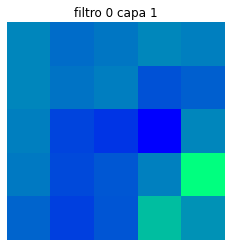

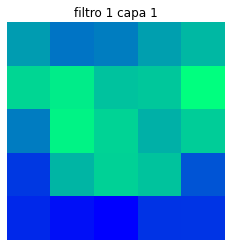

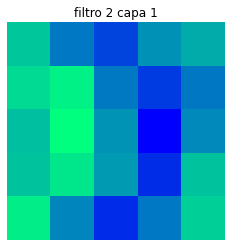

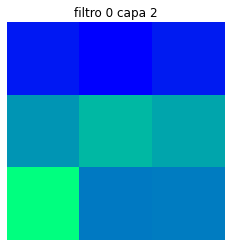

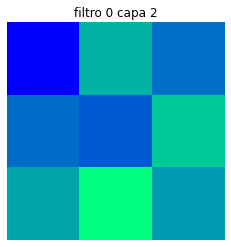

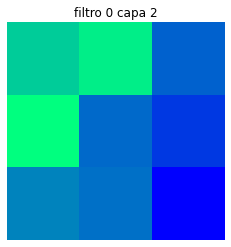

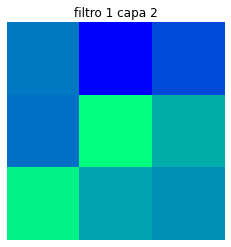

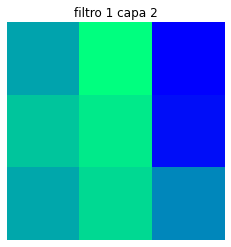

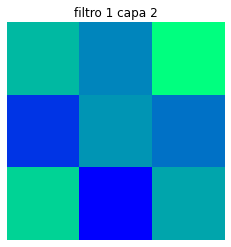

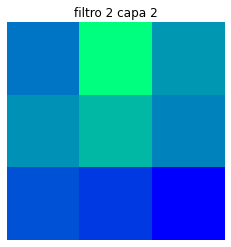

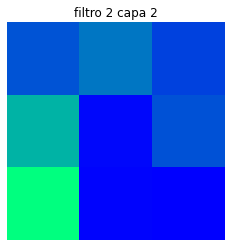

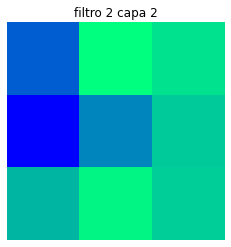

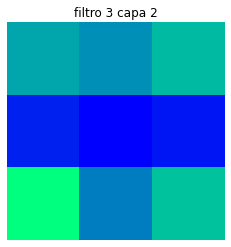

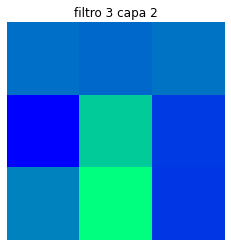

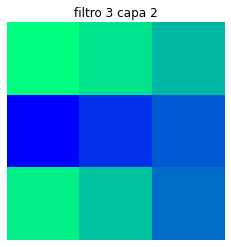

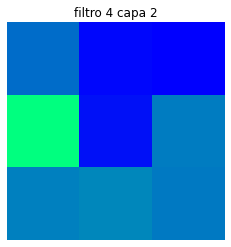

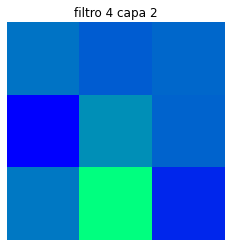

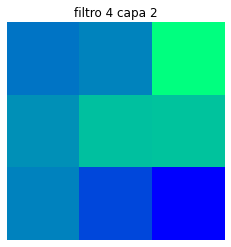

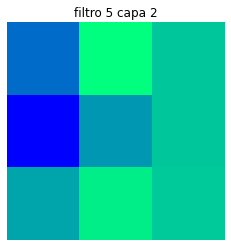

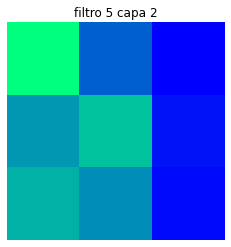

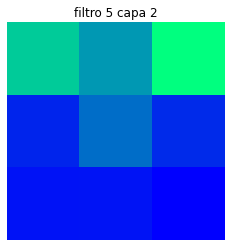

In [13]:
i = 0
for filtro in capa1:
    imshow(filtro[0,:,:],'filtro {} capa 1'.format(i),'winter')
    i+=1
i=0
for filtro1 in capa2:
    for filtro2 in filtro1:
        imshow(filtro2,'filtro {} capa 2'.format(i),'winter')
    i+=1    


El modelo considera que este número es un  5


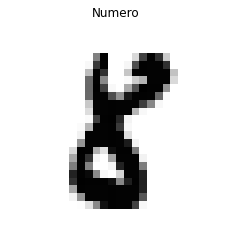

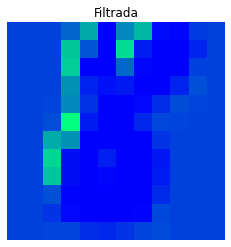

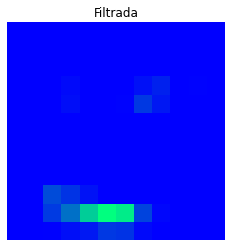

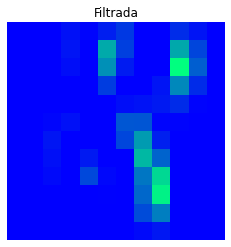

In [14]:
imagen = train_dic['val'][30][0]
o = model(imagen)
_,pred = torch.max(o,1)
print('El modelo considera que este número es un ',int(pred[0]))

imshow(imagen[0,0,:,:],'Numero','Greys')

procesada = model.features(imagen)

imshow(procesada[0,0,:,:].detach(),'Filtrada','winter')
imshow(procesada[0,1,:,:].detach(),'Filtrada','winter')
imshow(procesada[0,2,:,:].detach(),'Filtrada','winter')


In [15]:
procesada1 = model.features1(procesada)[0]


0


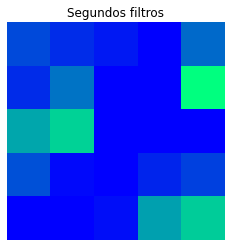

1


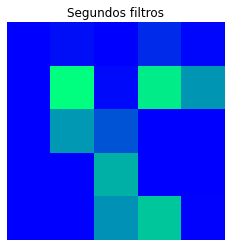

2


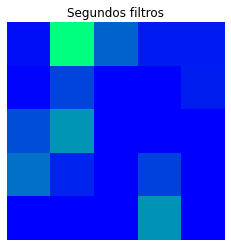

3


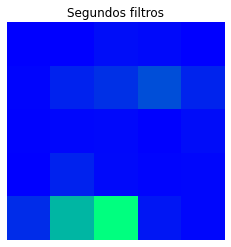

4


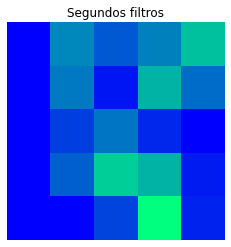

5


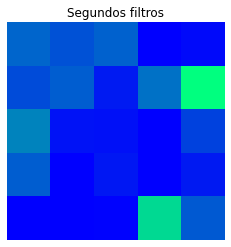

In [16]:
i=0
for imag in procesada1:
    print(i)
    i+=1
    imshow(imag.detach(),'Segundos filtros','winter')

### Bibliografia:
* Goodfellow-et-al. (2016). Deep Learning. MIT Press. http://www.deeplearningbook.org
* Convolution. Wikipedia. https://en.wikipedia.org/wiki/Convolution
* Kernel (image processing). Wikipedia. https://en.wikipedia.org/wiki/Kernel_(image_processing)